In [2]:
import os
from pathlib import Path, PurePath
import math
from fastai.vision.all import *
import torchaudio

# Dataset
Setting path, and checking that we have wav files.
samplerate (sr) is explicitly set, because we know that all the wav files in the deep ship is sampled at 32000Hz

In [3]:
path = Path('../dataset/DeepShip')
sr = 32000

In [4]:
fns =  get_files(path,'.wav')

In [5]:
fns

(#621) [Path('../dataset/DeepShip/Tug/20171202-37/071515.wav'),Path('../dataset/DeepShip/Tug/20171106a-5/162112.wav'),Path('../dataset/DeepShip/Tug/20171217a-59/050224.wav'),Path('../dataset/DeepShip/Tug/20171118c-15/185844.wav'),Path('../dataset/DeepShip/Tug/20171219a-60/210546.wav'),Path('../dataset/DeepShip/Tug/20171202a-38/145149.wav'),Path('../dataset/DeepShip/Tug/20171229b-68/200347.wav'),Path('../dataset/DeepShip/Tug/20171124-22/012051.wav'),Path('../dataset/DeepShip/Tug/20171223b-63/233721.wav'),Path('../dataset/DeepShip/Tug/20171118b-14/161506.wav')...]

In [6]:
def label_func(p : Path):
    if PurePath(p).parent.name == "AmbientSE": return []
    return [PurePath(p).parent.parent.name]

In [7]:
label_func(fns[30])

['Tug']

In [8]:
labels = {}
for f in fns:
    l = label_func(f)
    if len(l) ==0: labels["none"] = labels.setdefault("none",0) + 1
    else: labels[l[0]] = labels.setdefault(l[0],0) + 1
labels  

{'Tug': 69, 'Cargo': 109, 'none': 12, 'Tanker': 240, 'Passengership': 191}

# Signal processing
In signal processing it is known that one have to choose between spectral resolution (frequency) and temporal resolution (time).  
If you want to detect low frequencies, or close frequencies, you has to take a fourier transform of a longer time series.  
A longer time series means that changes in frequencies within that series gets smeered out, and harder/ impossible to catch.  
I generate two spectrograms, one for low frequencies (LF), and one for higher frequencies(HF).

## LF Spectrograms
Long Fourier Ttansforms(FTs) on CPUs is very comutational heavy. Levereging modern GPUs it becomes really fast.  
A FT of size of 32768 is chosen, because it is a power of 2, so that the Fast Fourier Transfer (FFT) algorithm can be used.  
32768 is a little bit bigger than the samplerate of the dataset (32000), which means we will have a frequencuy resolution of around 1Hz.  
The reason we want a good spectral resolution is that we want to catch periodical noise, that are close to each other in frequency

For example if a propeller spins at the rate of 60rpm, it will generate a noise at 1Hz.
A frequency resolution of 1Hz also means that 120 rpm (2Hz) will be its own frequency bin and not merged in the first.

FFTs assumes continuous signals. Sound is usually not, as it consists of many frequencies, whis periodically dont fit perfectly each frame of samples.  
the samples in each frame has to be shaded. That means reduced with some kind of window at the beginning and end.   
By default torchaudio uses hann window on the samples. This reduces bias in the spectrograms and is a good choise.  

80% ovelap is high. Sinse our dataset constist of shorter recordings, we need a high ovelap.  
Else the spectrograms becomes repetitive. This is because when missing samples, I simply copy the previus ones untill I have enough for a spectrogram. 

In [9]:
imgsize = 460
Fmax = sr / 2 # Nyquist. 
Nfft_lf = 32768 # 32768 is the cloeset power of 2 above the sample rate.  
Fbin_lf = Fmax / Nfft_lf
Nskip_lf = Nfft_lf //5  # 80% overlap  
rng_lf = Nskip_lf * (imgsize-1)
stft_lf = torchaudio.transforms.Spectrogram(Nfft_lf,hop_length=Nskip_lf, power=2,return_complex=False ).cuda()

In [10]:
print('LF frequency resolution {}Hz'.format(sr / Nfft_lf))
print('Recording lenght needed for each lf spectrogram {}s'.format(rng_lf / sr))

LF frequency resolution 0.9765625Hz
Recording lenght needed for each lf spectrogram 93.99459375s


## HF Spectrograms
Ship noise also modulates itself on higher frequencies. 
I dont do any signal processing on this modulation, and hope the network learns it.  
We need some overlap, because shading cuts away some of the data between each frame.    
But we also want as much data as possible. 25% overlap seems like a good balance.

A frame size of 1024 is chosen because it causes the frequency range to fit our image dimensions,  
if cut a litte at the lower frequencies.
That is not a problem, becuse there is much more details at these frequencies in our low frequency spectrogram. 

In [11]:
Nfft_hf = 1024
Fbin_hf = Fmax / Nfft_hf
Nskip_hf =(1024 * 3)//4 # 25% overlap
rng_hf = Nskip_hf * imgsize + Nfft_hf
stft_hf = torchaudio.transforms.Spectrogram(Nfft_hf,hop_length=Nskip_hf, power=2,return_complex=False ).cuda()

In [12]:
print('HF frequency resolution {}Hz'.format(sr / Nfft_hf))

HF frequency resolution 31.25Hz


## Normalizing
We need to normalize the spectograms so they fit the specs of an image.  
An image is usually represented with float values between 0 and 1, where 0 is black, and 1 is white, or the color for that channel.  
It is common to view spectograms in log scale because of the huge variations in magnitude of the different frequencies.  
If we subtract the mean, and divide by 2 std diviations, we will have around 95% of the data in the intervall [-1, 1].  
If we divide by two a second time, our data will be in the intervall [-0.5, 0.5]. 
Now we simply need to add .5 to have moast of our spectrogram data within the intervall [0, 1].  
Torch.clamp is used so that data below zero becomoes zero, and data above 1, becomes 1. 

In [13]:
def normSamp(audio):
    ret = audio - torch.mean(audio)
    return ret / torch.max(ret)

def normSpec(spec):
    # take the logarithm of the values
    ret = torch.log10(spec+1e-20)
    mean = torch.mean(ret)
    std = torch.std(ret)
    # Normalize each frame so its max 1, we dont need the extra dimension
    #return (ret / torch.transpose(torch.max(ret,2)[0],0,1))[0]
    #return (ret / torch.max(ret))[0]
    
    ret =  (ret - mean) / (std*4) + 0.5
    return torch.clamp(ret, min=0, max=1) 


## Reading  audio files
Moast of low level stuff is handled by torch audio.  
We dont have to care of file types or anything.   
The only preprocessing I do is appending copies of samples, if the file is for short for a spectrogram.  
If it is bigger, a random subset of samples is selected if rand is set to true.
This is the case when training, and not when validating.

In [14]:
def readWav(p: Path, rand=True):
    frames = torchaudio.info(p).num_frames
    last = frames-rng_lf
    wav = torch.Tensor()  
    # Repeat wav if not long enough
    while last < 0:
        wav = torch.cat((wav,torchaudio.load(p)[0]),1)
        last += frames
    # Random start point
    start = random.randint(0,last) if rand else int(last/2)
    
    # If enough frames
    if frames-rng_lf > 0:
        return torchaudio.load(p, num_frames=rng_lf, frame_offset=start)[0]
    else: 
        wav = torch.cat((wav,torchaudio.load(p)[0]),1)
        return wav[:,start:start+rng_lf]

## Generating spectrograms

In [15]:
print('LF frequency range {}Hz'.format(sr / Nfft_lf * imgsize))

LF frequency range 449.21875Hz


A RGB image consists of three channels. 449Hz is not that much, so we put a LF spectogram in the first and one in the second channel.  
Now, the frequency range of the two lf spectrograms is 899Hz. That means we so far do not use any information above 889Hz  
In the third channel we put a HF spectogram. The time range of a HF spectrogram is than LF, so a start position can be chosen with hf_idx.

In [30]:
def wavToSpecs(wavs : torch.Tensor, hf_idx=0):
    lf = stft_lf(wavs)[0]
    
    lf0 = normSpec(lf[:imgsize,:imgsize])
    lf1 = normSpec(lf[imgsize:imgsize*2,:imgsize])
    
    hf = stft_hf(wavs[:,hf_idx:hf_idx+rng_hf])[0]
    
    hf = normSpec(hf[12:imgsize+12,:imgsize])
    #return torch.stack((normSpec(lf[0, ]),mf, hf),0)
    return torch.stack((lf0,lf1,hf),0)


## Testing creation of spectrograms
This is very usefull, when dimensions are out of order.  

In [17]:
file = readWav(fns[0]).cuda()

In [18]:
spec = wavToSpecs(file)

In [19]:
spec.shape

torch.Size([3, 460, 460])

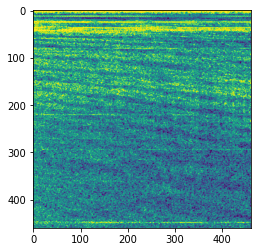

In [24]:
plt.imshow(spec[0].cpu())

# Preparing for training
Making transformation classes using fastai midlevel api.  
The Spectrogram class is just to have a convenient way to display the different spectrograms. 

In [20]:
class Spectrogram(TensorImageBase):
    """Type to represent a spectogram which knows how to show itself"""
    @classmethod
    def create(cls, o: Tensor):
        return cls(o)
    
    def show(self, figsize=None, ctx=None, **kwargs): 
        channels = self.shape[0]
        t = self
        if not isinstance(t, Tensor): return ctx
        if figsize is None: figsize=(10,10)   
        return show_images(t, nrows=1, ncols=channels)

In [26]:
# Make a fastai Transform
class SpectrogramTransform(RandTransform):
    "A transform handler for multiple `spect` transforms"
    split_idx,order=None,0  # 0 = HIGH prio
    def __init__(self): 
        store_attr() 
        
    def before_call(self, b, split_idx):
        self.idx = split_idx
    def encodes(self, p : Path):
        
        if self.idx == 0: #Train transform
            # Select random start for hf stft during training.
            hf_idx = random.randint(0,rng_lf-rng_hf)
            wav = readWav(p, True)
        else: #Valid transform
            # set center range start as hf stft during validation. 
            hf_idx = (rng_lf-rng_hf) //2
            wav = readWav(p, False)
        return Spectrogram.create(wavToSpecs(wav.cuda(), hf_idx))
    
def get_wavs(p : Path) :
    return get_files(p,'.wav')

## Dataloaders
MultiCategorty is used so we can train with noise.
This makes the network give us a mask, for which label is present, including propability.  
That is usefull if we have more than one class present in a recording.  

In [27]:
#norm = Normalize.from_stats(*imagenet_stats)
db = DataBlock(blocks=(TransformBlock(type_tfms=SpectrogramTransform),  MultiCategoryBlock),
               get_items = get_wavs,
               get_y = label_func,
               splitter = RandomSplitter(valid_pct=0.2, seed=33)
               #item_tfms=ImgTransform(),
               #item_tfms=PolarTransform
               #batch_tfms= norm  
             )

`num_workers` has to be set to zero. 
This is because we can not have several threads try to create spectograms at the same time. This is not a python limitation but rather a python-cuda thing.   
I have initiated the STFTs in the main thread (the notebook). Maybe it is possible to create new transform instaces in each worker,  
but it does not make sense. long STFTs requice a lot of GPU memory, creating new worker transforms, would have forced me to reduce batch size.  

A better way would have been to put the transformation from samples to spectrograms into the neural network model itself.  
In this notebook i have used the midlevel fastapi for the transforms, however it is posible to dive down in pytorch model,  
as I have done in the tensorflow notebook under the Experiments folder.

In [28]:
dls = db.dataloaders(path, bs=32, num_workers=0)

Passengership
Passengership
Tug
Tug


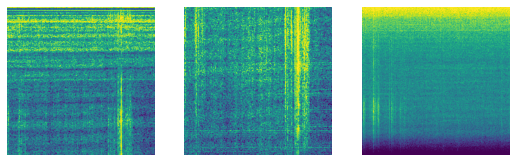

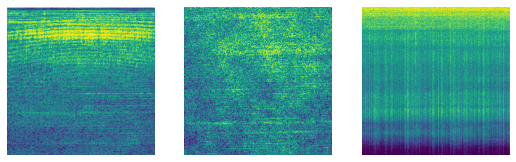

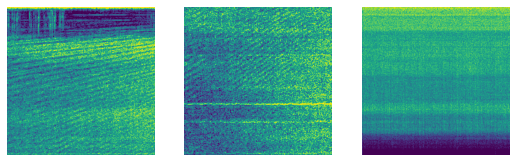

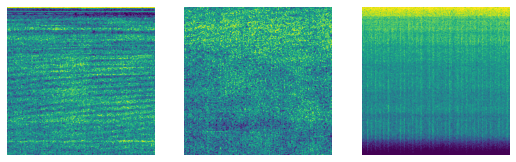

In [29]:
dls.train.show_batch(max_n=4, nrows=1)

# Training

Finetuning resnet50 trained on imagenet.  
This works surpringly well.

Defining a save model callback saves the best results, which loads them when training finishes.  
MixUp blends labels, and helps with accuracy. 
accuracy_multi is better metric to to look at compared to loss, as it directly interpeted for how well the model performs on the validation set.

In [31]:
learn = cnn_learner(dls, resnet50,  n_in=3, pretrained=True,
                    loss_func=BCEWithLogitsLossFlat(), 
                    metrics=[accuracy_multi]).to_fp16()

/home/user/miniconda/lib/python3.9/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


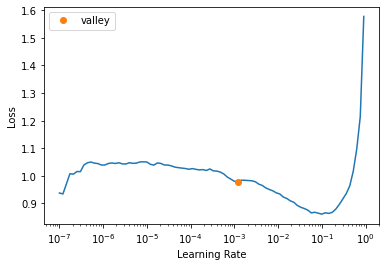

In [26]:
lr = learn.lr_find()

In [27]:
cbs = [SaveModelCallback(fname='stft_lf',monitor='accuracy_multi'), MixUp()]
learn.fine_tune(200, lr.valley, cbs=cbs)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.001953,0.635511,0.643145,00:18


Better model found at epoch 0 with accuracy_multi value: 0.6431451439857483.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.869234,0.742872,0.596774,00:19
1,0.869704,0.658391,0.647177,00:18
2,0.851799,0.641527,0.679435,00:19
3,0.832534,0.599357,0.677419,00:18
4,0.818575,0.569742,0.707661,00:18
5,0.798613,0.591080,0.695565,00:19
6,0.776474,0.575953,0.695565,00:19
7,0.763327,0.565857,0.717742,00:19
8,0.755814,0.563865,0.729839,00:19
9,0.739315,0.542437,0.731855,00:19


Better model found at epoch 0 with accuracy_multi value: 0.5967742204666138.
Better model found at epoch 1 with accuracy_multi value: 0.6471773982048035.
Better model found at epoch 2 with accuracy_multi value: 0.6794354915618896.
Better model found at epoch 4 with accuracy_multi value: 0.7076612710952759.
Better model found at epoch 7 with accuracy_multi value: 0.7177419066429138.
Better model found at epoch 8 with accuracy_multi value: 0.7298387289047241.
Better model found at epoch 9 with accuracy_multi value: 0.7318548560142517.
Better model found at epoch 10 with accuracy_multi value: 0.75.
Better model found at epoch 11 with accuracy_multi value: 0.7620967626571655.
Better model found at epoch 12 with accuracy_multi value: 0.7903226017951965.
Better model found at epoch 15 with accuracy_multi value: 0.7983871102333069.
Better model found at epoch 17 with accuracy_multi value: 0.8326612710952759.
Better model found at epoch 24 with accuracy_multi value: 0.8487903475761414.
Better 

# Results
We observe that the accuracy score at epoch 124 is 93.75%. 

## Exporting results for inference

In [28]:
#learn.load('stft_lf')

In [30]:
learn.export('../models/resnet50-93')